In [1]:
import numpy as np
import jax.numpy as jnp
import os
import pickle
import pandas as pd

datasets = ["LorenzDataset","FitzHughDataset", "NPendulum"]


In [2]:

import matplotlib.colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)[5:]
perm = [4,0,2,3,1]
colors=[colors[perm[i]] for i in range(len(perm))]

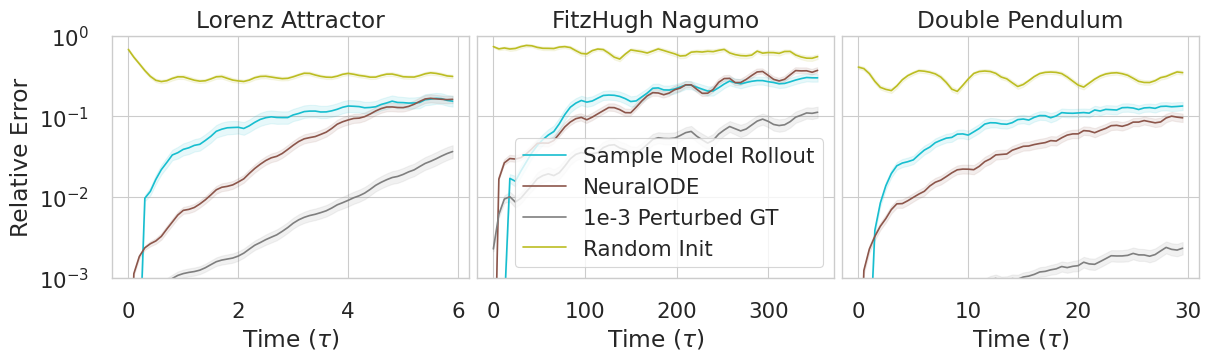

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
#rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.75)

names = ['Lorenz Attractor','FitzHugh Nagumo', 'Double Pendulum']
T = np.linspace(0,1,60) #TODO get real T
fig, ax = plt.subplots(1,3, figsize=(12,3.5), layout='constrained',sharey=True)
ax[0].set_ylabel('Relative Error')
for a,dataset,i in zip(ax,datasets,range(3)):
    a.set_ylim(1e-3,1)
    a.set_yscale('log')
    a.set_xlabel(r'Time $(\tau)$')
    a.set_title(names[i])
    with open(f'{dataset}_Zs', 'rb') as f:
        (T_long,trajectories,test_x) = pickle.load(f)
    with open(f'{dataset}_rollouts', 'rb') as f:
        data_dict = pickle.load(f)
    for k,(name, vals) in enumerate(data_dict.items()):
        rel_errs,rel_stds = vals
        a.plot(T_long-T_long[0],rel_errs,label=name,color=colors[k])
        a.fill_between(T_long-T_long[0], rel_errs/rel_stds, rel_errs*rel_stds,alpha=.1,color=colors[k])
    if i==1: a.legend() 
handles, labels = ax[0].get_legend_handles_labels()
plt.savefig('rollouts.pdf') 

In [4]:
dataset = "LorenzDataset"
with open(f'{dataset}_sde_event_samples', 'rb') as f:
    sde_event_samples = pickle.load(f)
    
with open(f'{dataset}_cond_sde_samples', 'rb') as f:
    sde_samples = pickle.load(f)
    
with open(f'{dataset}_uncond_sde_samples', 'rb') as f:
    uncond_sde_samples = pickle.load(f)
    
with open(f'{dataset}_expanded_rollouts', 'rb') as f:
    preds = pickle.load(f)
with open(f'{dataset}_gt', 'rb') as f:
    z_gt = pickle.load(f)
    
upper = jnp.quantile(preds,.8,0)
lower = jnp.quantile(preds,.2,0)
#T_long = T
expanded = z_gt[::20]

In [5]:
with open(f'{dataset}_Zs', 'rb') as f:
    (T_long,trajectories,test_x) = pickle.load(f)

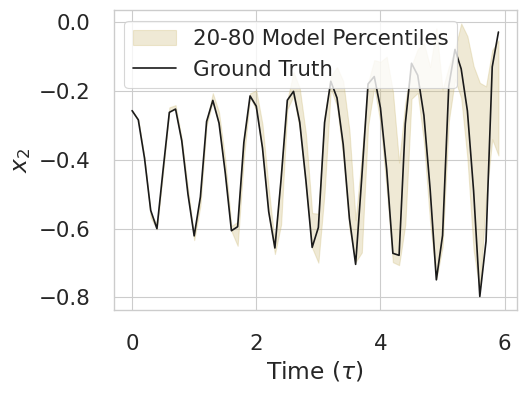

In [6]:
i=13
plt.figure(figsize=(4*1.3, 3*1.3))
plt.fill_between(T_long-T_long[0],lower[i,:,1],upper[i,:,1],alpha=.3,color='y',label='20-80 Model Percentiles')
plt.plot(T_long-T_long[0],expanded[i,:,1],label='Ground Truth',color='k')
plt.ylabel(r'$x_2$')
plt.xlabel(r'Time $(\tau)$')
plt.legend()
plt.savefig('lorenz_unc_1.pdf', bbox_inches='tight')

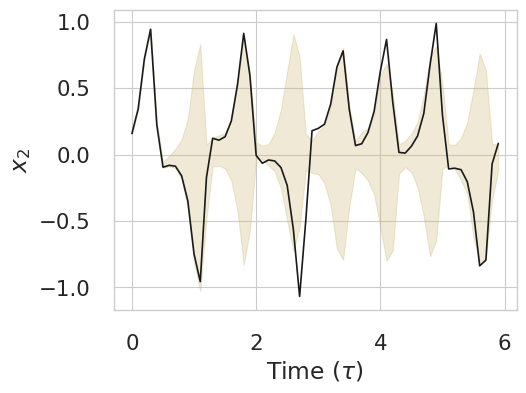

In [7]:
i=2
plt.figure(figsize=(4*1.3, 3*1.3))
plt.fill_between(T_long-T_long[0],lower[i,:,1],upper[i,:,1],alpha=.3,color='y',label='20-80 Model Percentiles')
plt.plot(T_long-T_long[0],expanded[i,:,1],label='Ground Truth',color='k')
plt.ylabel(r'$x_2$')
plt.xlabel(r'Time $(\tau)$')
#plt.legend()
plt.savefig('lorenz_unc_2.pdf', bbox_inches='tight')

In [8]:
from jax import vmap
from functools import partial
q = .1+(np.arange(9))/10.
qs = jnp.quantile(preds,q,axis=0)
flat_qs = qs.reshape(9,-1).T
flat_gts = z_gt[::20].reshape(-1)
bins = vmap(partial(jnp.digitize,right=True))(flat_gts,flat_qs)
binvals = jnp.stack([(bins.reshape(qs.shape[1:])<=i).mean(axis=(0,-1)) for i in range(10)],0)

In [9]:
binvals.shape

(10, 60)

In [10]:
np.arange(60).reshape(6,10).mean(-1)

array([ 4.5, 14.5, 24.5, 34.5, 44.5, 54.5])

In [11]:
agg_binvals = binvals.reshape(10,10,6).mean(-1)

In [12]:
tt = T_long-T_long[0]
T_long = T_long-T_long[0]

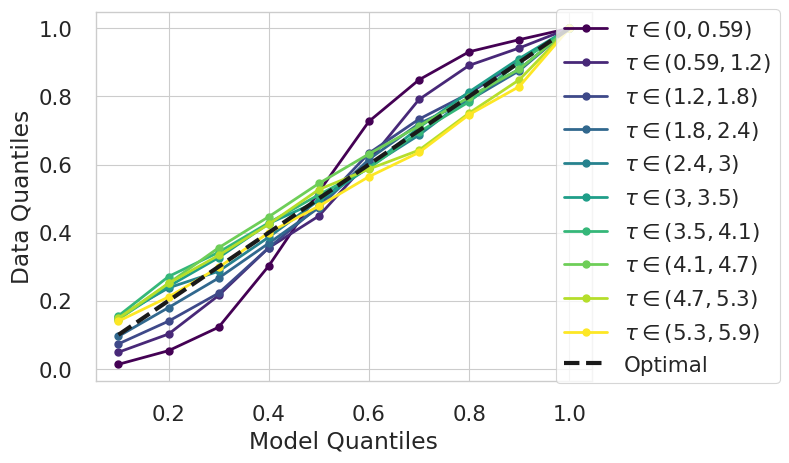

In [13]:
Ts = np.linspace(0,1,agg_binvals.shape[1])
colors = plt.cm.viridis(Ts)
#plt.set_cmap('jet')
#plt.plot(np.arange(binvals.shape[0]),binvals)
for bval,c in zip(agg_binvals.T[:],colors):
    plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,marker='.',color=c,markersize=10,lw=2)
    #plt.plot((1+np.arange(agg_binvals.shape[0]))/10,bval,color=c,alpha=.5,lw=2)
plt.plot((1+np.arange(agg_binvals.shape[0]))/10,(1+np.arange(agg_binvals.shape[0]))/10.,'--',lw=3,color='k')
plt.xlabel('Model Quantiles')
plt.ylabel('Data Quantiles')

plt.legend([r"$\tau\in({:.2g},{:.2g})$".format(tt[-1]*a/10,tt[-1]*b/10) for (a,b) in zip(range(10),range(1,11))]+['Optimal'],bbox_to_anchor=(1.4, .5), loc='center right', ncol=1)
plt.savefig('quantiles.pdf', bbox_inches='tight')

In [14]:
dataset = "LorenzDataset"
with open(f'{dataset}_sde_event_samples', 'rb') as f:
    sde_event_samples = pickle.load(f)
with open(f'{dataset}_bad_sde_event_samples', 'rb') as f:
    bad_sde_event_samples = pickle.load(f)    
with open(f'{dataset}_cond_sde_samples', 'rb') as f:
    sde_samples = pickle.load(f)
    
with open(f'{dataset}_uncond_sde_samples', 'rb') as f:
    uncond_sde_samples = pickle.load(f)
    
with open(f'{dataset}_expanded_rollouts', 'rb') as f:
    preds = pickle.load(f)
with open(f'{dataset}_gt', 'rb') as f:
    z_gt = pickle.load(f)
with open(f'{dataset}_Zs', 'rb') as f:
    (T_long,trajectories,test_x) = pickle.load(f)

In [14]:
def lorenz_C(x):
    fourier_mag = jnp.abs(jnp.fft.rfft(x[...,0],axis=-1))
    return -(fourier_mag[...,1:].mean(-1)-.6)

def fitz_C(x):
    C = jnp.max(x[...,:2].mean(-1),-1)-2.5
    return C

def pendulum_C(x):
    raise NotImplementedError

constraints = {'FitzHughDataset':fitz_C,
          'LorenzDataset': lorenz_C,
          'NPendulum':pendulum_C,
          }
event_constraint = constraints[dataset]

In [16]:
Zs = trajectories
event_distribution = event_constraint(Zs)
events_train = Zs[event_constraint(Zs)>0]
events_test = test_x[event_constraint(test_x)>0]

2022-10-14 06:07:56.139411: E external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:1363] The CUDA linking API did not work. Please use XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1 to bypass it, but expect to get longer compilation time due to the lack of multi-threading.


XlaRuntimeError: UNKNOWN: an illegal memory access was encountered
in external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_asm_compiler.cc(55): 'cuLinkCreate(0, nullptr, nullptr, &link_state)'

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(4*1.3, 3*1.3),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.5, hspace=.2)
#ax[0].set_ylabel('Density')
#ax[2].set_xlabel(r'$C(x)$')
ax[1].plot(T,sde_event_samples[13:20,:,0].T,alpha=1,label = 'Conditional diffusion samples x|E')
ax[1].text(4, .9, 'Conditional Samples', fontsize=14)
#ax[2].set_yticklabels([])
#ax[1].plot(T,bad_sde_event_samples[8:15,:,0].T,alpha=1, label = 'Manifold Constraints')
#ax[1].text(-1.6, 5.5, 'Naive Constraints', fontsize=14)
ax[0].plot(T,events_train[4:11,:,0].T,alpha=1, label='True distribution x|E')
ax[0].text(4, .9, 'True events', fontsize=14)
ax[0].set_ylabel(r'$x_0$')
ax[1].set_ylabel(r'$x_0$')
ax[1].set_xlabel(r'Time $\tau$')
plt.savefig(f'{dataset}_conditional_trajectories.pdf', bbox_inches='tight')

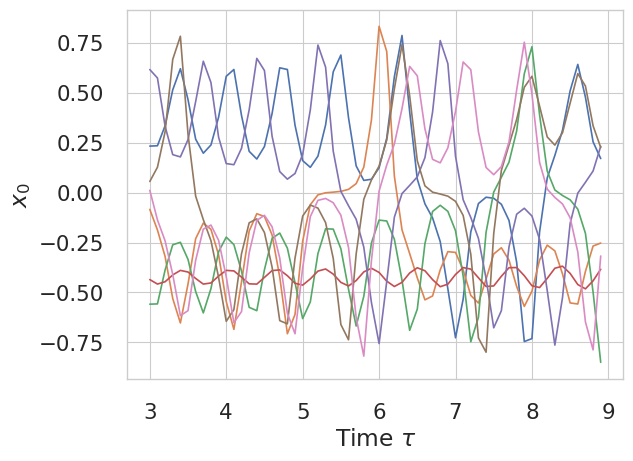

In [215]:
T = T_long
plt.plot(T,trajectories[:7,:,0].T)
plt.xlabel(r'Time $\tau$')
plt.ylabel(r'$x_0$')
#plt.title('Example model events')
plt.savefig(f'{dataset}_trajectories.pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Data samples')

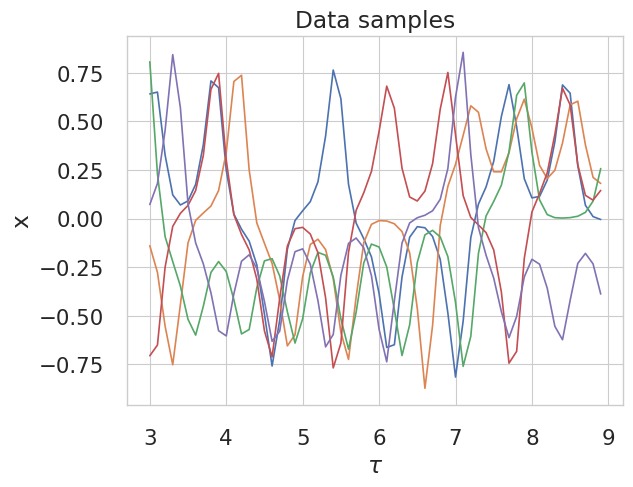

In [135]:

plt.plot(T,test_x[10:15,:,0].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('Data samples')

Text(0.5, 1.0, 'Example events in dataset')

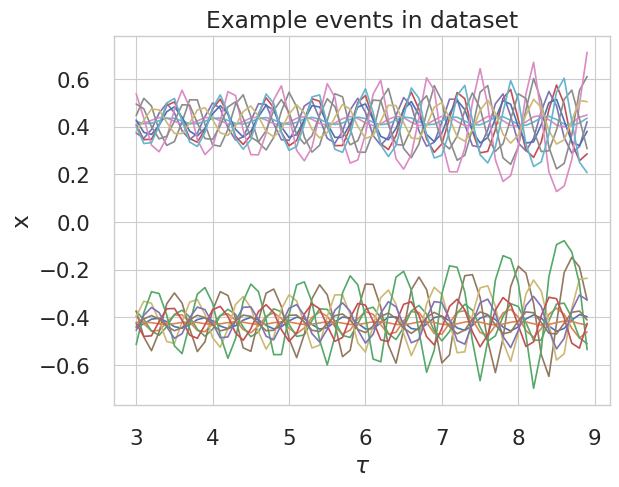

In [136]:
plt.plot(T,events_test[:20,:,0].T)
plt.xlabel(r'$\tau$')
plt.ylabel('x')
plt.title('Example events in dataset')

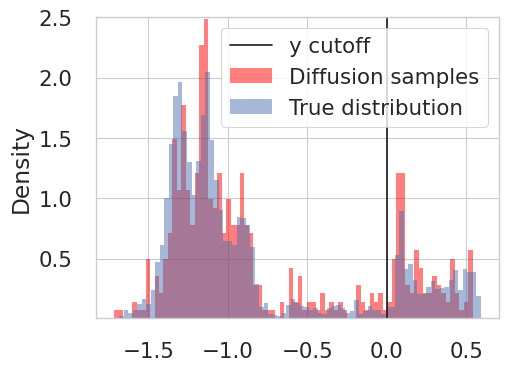

In [140]:

plt.figure(figsize=(4*1.3, 3*1.3))
plt.hist(np.array(event_constraint(sde_samples)),bins=80,color='red',density=True,alpha=.5,lw=0.0)
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
plt.hist(np.array(event_constraint(Zs[:4000])),bins=80,color='b',density=True,alpha=.5,lw=0.0)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
#plt.xlabel(r'$C(x)$')
plt.ylabel('Density')
plt.ylim(1e-2,2.5)
plt.axvline(x=0,color='k')
plt.legend(['y cutoff','Diffusion samples','True distribution'])
plt.savefig(f'{dataset}_unconditional.pdf', bbox_inches='tight')

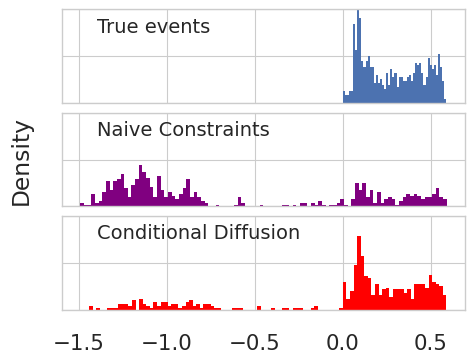

In [141]:
fig, ax = plt.subplots(3,1, figsize=(4*1.3, 3*1.3),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.25, hspace=.1)
#ax[0].set_ylabel('Density')
top = 5
plt.ylim(0,top)
#ax[2].set_xlabel(r'$C(x)$')
ax[2].hist(np.array(event_constraint(sde_event_samples[:,:])),bins=100,color='red',density=True,alpha=1,label = 'Conditional diffusion samples x|E',lw=0.0)
ax[2].text(-1.4, (5.3/7)*top, 'Conditional Diffusion', fontsize=14)
ax[2].set_yticklabels([])
ax[1].hist(np.array(event_constraint(bad_sde_event_samples)),bins=100,color='purple',density=True,alpha=1, label = 'Manifold Constraints',lw=0.0)
ax[1].text(-1.4, (5.3/7)*top, 'Naive Constraints', fontsize=14)
ax[0].hist(np.array(event_constraint(events_train)),bins=50,color='b',density=True,alpha=1, label='True distribution x|E',lw=0.0)
ax[0].text(-1.4, (5.3/7)*top, 'True events', fontsize=14)
ax[1].set_ylabel('Density')

plt.savefig(f'{dataset}_conditional.pdf', bbox_inches='tight')
#ax[2].legend()
#ax[2].set_ylabel('Density')

In [152]:
# plt.figure(figsize=(4*1.3, 3*1.3))
# plt.hist(np.array(event_constraint(sde_event_samples[:,:])),bins=100,color='red',density=True,alpha=.5)
# plt.hist(np.array(event_constraint(bad_sde_event_samples[:,:])),bins=100,color='g',density=True,alpha=.5)
# #plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
# plt.hist(np.array(event_constraint(events_train)),bins=50,color='y',density=True,alpha=.5)

# #plt.yscale('log')
# #plt.xlabel(r'$\max_\tau x(\tau)$')
# plt.axvline(0,color='k')
# plt.xlabel(r'$C(x)$')#r'$.6-||F[x]_{1:}||_1$')
# plt.ylabel('density')
# plt.ylim(1e-2,6)
# plt.legend(['y cutoff','Conditional diffusion samples x|E','True distribution x|E'])

In [23]:
(event_constraint(sde_event_samples)>0).mean()

DeviceArray(0.80200005, dtype=float32)

In [24]:

# plt.plot(T,events_test[0,:,:2].mean(-1))
# plt.plot(T,2*np.ones_like(T),color='k')
# plt.xlabel(r'Time ($\tau$)')
# plt.ylabel(r'$x(\tau)$')
# plt.legend(['example spike', 'our cutoff y'])

In [13]:
dataset = "FitzHughDataset"
with open(f'{dataset}_sde_event_samples', 'rb') as f:
    sde_event_samples = pickle.load(f)
with open(f'{dataset}_bad_sde_event_samples', 'rb') as f:
    bad_sde_event_samples = pickle.load(f)    
with open(f'{dataset}_cond_sde_samples', 'rb') as f:
    sde_samples = pickle.load(f)
    
with open(f'{dataset}_uncond_sde_samples', 'rb') as f:
    uncond_sde_samples = pickle.load(f)
    
with open(f'{dataset}_expanded_rollouts', 'rb') as f:
    preds = pickle.load(f)
with open(f'{dataset}_gt', 'rb') as f:
    z_gt = pickle.load(f)
with open(f'{dataset}_Zs', 'rb') as f:
    (T_long,trajectories,test_x) = pickle.load(f)
    
T_long = T_long-T_long[0]
event_constraint = constraints[dataset]
Zs = trajectories
event_distribution = event_constraint(Zs)
events_train = Zs[event_constraint(Zs)>0]
events_test = test_x[event_constraint(test_x)>0]

NameError: name 'constraints' is not defined

In [6]:
import numpy as np
cond_likelihoods = np.array([1208.745, 1242.1211])#,1231.9181])
uncond_likelihoods = np.array([1206.585,1242.2633])#,1235.0409])#,1206.9307]

In [15]:
def fitz_C(x):
    C = jnp.max(x[...,:2].mean(-1),-1)-2.5
    return C

In [20]:
val1 = (fitz_C(uncond_sde_samples)>0).mean()

In [21]:
val2 = jnp.exp((uncond_likelihoods-cond_likelihoods).mean())

In [22]:
val3 = jnp.exp(uncond_likelihoods-cond_likelihoods).mean()

In [23]:
val4 = (fitz_C(trajectories)>0).mean()

In [66]:
vals = {'Model rate':val1,'Importance sampling': val3, 'Direct estimation': val2, 'True rate':val4}
vals = {k:np.array(v).item() for k,v in vals.items()}

In [67]:
names,vals2 = list(zip(*list(vals.items())))
perm = np.array([3,0,2,1])
names2 = [names[perm[i]] for i in range(4)]
vals3 = [vals2[perm[i]] for i in range(4)]
df = pd.DataFrame({'names':names2,'vals':vals3})

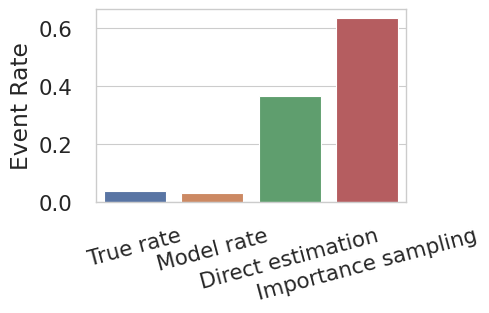

In [73]:
import seaborn as sns
import pandas as pd
plt.figure(figsize=(4,2.5))
sns.barplot(data=df,x="names", y="vals")
plt.ylabel('Event Rate')
plt.xticks(rotation=15)
plt.xlabel('')
plt.savefig(f'barplot.pdf', bbox_inches='tight')
#plt.bar(vals.values())

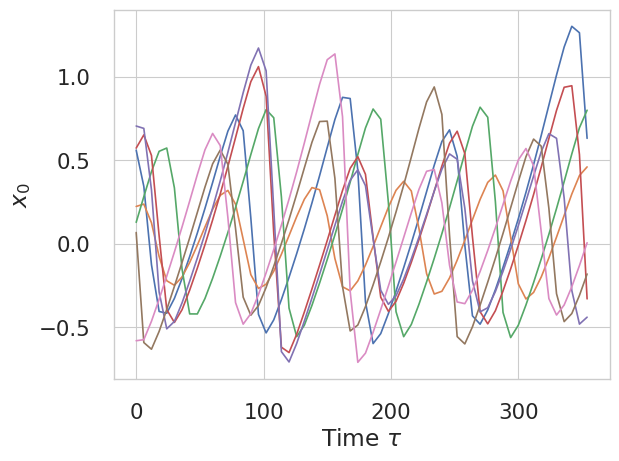

In [19]:
T = T_long
plt.plot(T,trajectories[7:14,:,0].T)
plt.xlabel(r'Time $\tau$')
plt.ylabel(r'$x_0$')
#plt.title('Example model events')
plt.savefig(f'{dataset}_trajectories.pdf', bbox_inches='tight')

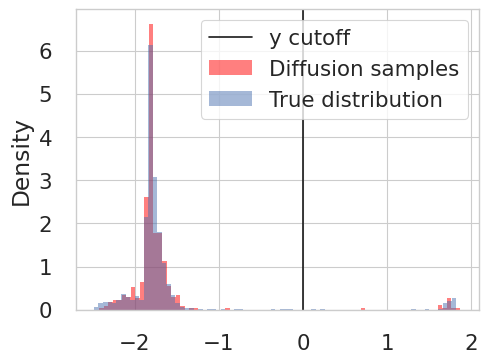

In [143]:
# plt.figure(figsize=(4*1.3, 3*1.3))

# plt.hist(np.array(event_constraint(sde_event_samples[:,:])),bins=100,color='red',density=True,alpha=.4,label = 'Conditional diffusion samples x|E')
# plt.hist(np.array(event_constraint(bad_sde_event_samples[:,:])),bins=100,color='g',density=True,alpha=.4, label = 'Manifold Constraints')
# #plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
# plt.hist(np.array(event_constraint(events_train)),bins=50,color='b',density=True,alpha=.4, label='True distribution x|E')

# #plt.yscale('log')
# #plt.xlabel(r'$\max_\tau x(\tau)$')
# plt.axvline(0,color='k',label = 'y cutoff')
# plt.xlabel(r'$C(x)$')#r'$.6-||F[x]_{1:}||_1$')
# plt.ylabel('density')
# plt.ylim(1e-2,6)
# plt.legend()
# #plt.legend(['y cutoff',,'True distribution x|E'])


plt.figure(figsize=(4*1.3, 3*1.3))
plt.hist(np.array(event_constraint(sde_samples)),bins=80,color='red',density=True,alpha=.5,lw=0.0)
#plt.hist(np.array(ode_samples[:,:timesteps,:2].mean(-1).max(-1)),bins=100,color='g',density=True,alpha=.2)
plt.hist(np.array(event_constraint(Zs[:4000])),bins=80,color='b',density=True,alpha=.5,lw=0.0)

#plt.yscale('log')
#plt.xlabel(r'$\max_\tau x(\tau)$')
#plt.xlabel(r'$C(x)$')
plt.ylabel('Density')
#plt.ylim(1e-2,2.5)
plt.axvline(x=0,color='k')
plt.legend(['y cutoff','Diffusion samples','True distribution'])
plt.savefig(f'{dataset}_unconditional.pdf', bbox_inches='tight')

In [47]:
all_bad = []
for i in range(5):
    with open(f'{dataset}_bad_sde_event_samples_{i}', 'rb') as f:
        all_bad.append(pickle.load(f))

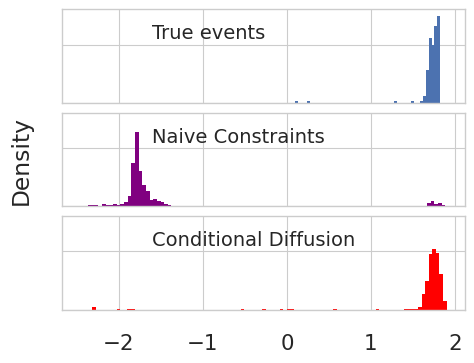

In [150]:
fig, ax = plt.subplots(3,1, figsize=(4*1.3, 3*1.3),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.25, hspace=.1)
#ax[0].set_ylabel('Density')
ax[0].set_ylim(0,8)
ax[1].set_ylim(0,8)
ax[2].set_ylim(0,8)
#ax[2].set_xlabel(r'$C(x)$')
ax[2].hist(np.array(event_constraint(sde_event_samples[:,:])),bins=100,color='red',density=True,alpha=1,label = 'Conditional diffusion samples x|E',lw=0.0)
ax[2].text(-1.6, 5.5, 'Conditional Diffusion', fontsize=14)
ax[2].set_yticklabels([])
ax[1].hist(np.array(event_constraint(bad_sde_event_samples)),bins=100,color='purple',density=True,alpha=1, label = 'Manifold Constraints',lw=0.0)
ax[1].text(-1.6, 5.5, 'Naive Constraints', fontsize=14)
ax[0].hist(np.array(event_constraint(events_train)),bins=50,color='b',density=True,alpha=1, label='True distribution x|E',lw=0.0)
ax[0].text(-1.6, 5.5, 'True events', fontsize=14)
ax[1].set_ylabel('Density')
plt.savefig(f'{dataset}_conditional.pdf', bbox_inches='tight')
#ax[2].legend()
#ax[2].set_ylabel('Density')
#ax.legend()

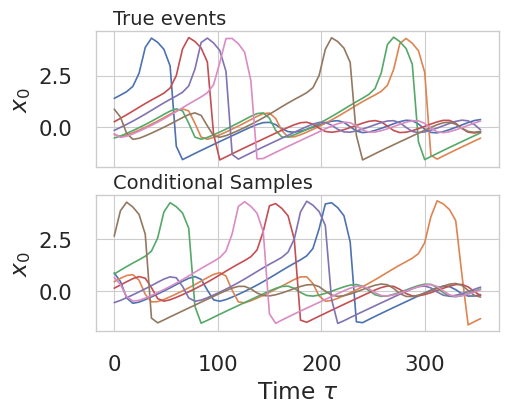

In [184]:
fig, ax = plt.subplots(2,1, figsize=(4*1.3, 3*1.3),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.5, hspace=.2)
#ax[0].set_ylabel('Density')
#ax[2].set_xlabel(r'$C(x)$')
ax[1].plot(T,sde_event_samples[3:10,:,0].T,alpha=1,label = 'Conditional diffusion samples x|E')
ax[1].text(-1.6, 5, 'Conditional Samples', fontsize=14)
#ax[2].set_yticklabels([])
#ax[1].plot(T,bad_sde_event_samples[8:15,:,0].T,alpha=1, label = 'Manifold Constraints')
#ax[1].text(-1.6, 5.5, 'Naive Constraints', fontsize=14)
ax[0].plot(T,events_train[4:11,:,0].T,alpha=1, label='True distribution x|E')
ax[0].text(-1.6, 5, 'True events', fontsize=14)
ax[0].set_ylabel(r'$x_0$')
ax[1].set_ylabel(r'$x_0$')
ax[1].set_xlabel(r'Time $\tau$')
plt.savefig(f'{dataset}_conditional_trajectories.pdf', bbox_inches='tight')

In [151]:
# for bad,c in zip(all_bad,colors):
#     plt.hist(np.array(event_constraint(bad)),bins=100,color=c,density=True,alpha=1, label = 'Manifold Constraints')
#     plt.show()

In [74]:
import ode_datasets
dt = 0.01 # .5
bs = 500 # 401
#ds = ode_datasets.NPendulum(N=4000+bs,n=2,dt=dt)
# ds = ode_datasets.LorenzDataset(N=4000+bs,dt=dt,integration_time=7)
ds = ode_datasets.LorenzDataset(N=40+bs,dt=dt,integration_time=20)

thetas  = ds.Zs[bs:,:60]
# test_x = ds.Zs[:bs,:60]
test_x = ds.Zs[:bs,:]

/home/marc/anaconda3/envs/diff2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:13<00:00,  3.94it/s]


In [75]:
import jax
import jax.numpy as jnp

In [76]:
def lorenz_C(x):
    fourier_mag = jnp.abs(jnp.fft.rfft(x[...,0],axis=-1))
    return -(fourier_mag[...,1:].mean(-1)-.6)

Cs = jax.vmap(lorenz_C)(test_x) > 0
extreme_indices = jnp.where(Cs)[0]
extreme_indices = extreme_indices[:10]
extreme_indices

DeviceArray([ 26,  68,  90,  99, 110, 223, 293, 311, 315, 323], dtype=int32)

In [77]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

import matplotlib
matplotlib.rcParams.update({'font.size': 14})
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
#rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.75)

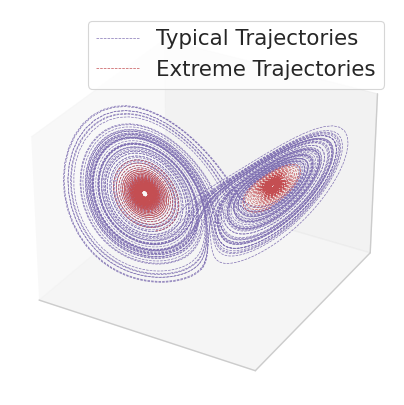

In [78]:
dt = 0.01
num_steps = 400 # 10000

# xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
# xyzs[0] = (0., 1., 1.05)  # Set initial values
# # Step through "time", calculating the partial derivatives at the current point
# # and using them to estimate the next point
# for i in range(num_steps):
#     xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt
# Plot
ax = plt.figure(figsize=(5, 5)).add_subplot(projection='3d')

# ax.plot(*xyzs.T, lw=0.5)
# Plot 'regular' trajectories.
first = True
for i in range(5):
  xyzs = test_x[i]
  label = 'Typical Trajectories' if first else None
  first = False
  ax.plot(*xyzs.T, color='C4', linestyle='dashed', lw=.5, label=label)

first = True
for i in range(2,7):
  xyzs = test_x[extreme_indices[i]]
  label = 'Extreme Trajectories' if first else None
  first = False
  ax.plot(*xyzs.T, color='C3', linestyle='dashed', lw=.5, label=label)
# xyzs = test_x[13]
# ax.plot(*xyzs.T, lw=0.5)
# xyzs = test_x[13]
# ax.plot(*xyzs.T, lw=0.5)

ax.legend()
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("Lorenz Attractor")

# plt.show()
# plt.savefig('plot.pdf')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.savefig('lorenz.pdf', bbox_inches='tight')

In [79]:
import numpy as np
class FitzHughDataset(ode_datasets.ODEDataset):
  """FitzHugh dynamics from https://arxiv.org/pdf/1803.06277.pdf."""
  burnin_time = 1500

  def __init__(self,
               *args,
               dt: float = 6.,
               integration_time: float = 4000,
               a0=-.025794,
               **kwargs):
    self.a0 = a0
    super().__init__(*args, dt=dt, integration_time=integration_time, **kwargs)

  def dynamics(self, z: jnp.ndarray, t: float) -> jnp.ndarray:
    z = z / 5.
    # a = jnp.ones(2) * (-.025794)
    a = jnp.ones(2) * self.a0
    c = jnp.ones(2) * .02 
    b = jnp.array([.0065, .0135])
    k = .128
    coupling = 1
    n = z.shape[0] // 2
    assert n == 2, 'System should have 4 components'
    xs = z[:n]
    ys = z[n:]
    xdot = xs * (a - xs) * (xs - 1) - ys + k * coupling * (xs[::-1] - xs)
    ydot = b * xs - c * ys
    return jnp.concatenate([xdot, ydot]) * 5.

  def sample_initial_conditions(self, bs: int) -> np.ndarray:
    return np.random.randn(bs, 4) * .2

In [85]:

dt = 0.1
# bs = 400
bs = 400
# ds = ode_datasets.FitzHughDataset(N=4000+bs,dt=dt,integration_time=3000)
# ds = FitzHughDataset(N=4000+bs,dt=dt,integration_time=3000)
ds = FitzHughDataset(N=400+bs,dt=dt,integration_time=3000,a0=-.025794)

train_x = ds.Zs[bs:,:1200]
# train_x = ds.Zs[bs:,:]
test_x = ds.Zs[:bs,:1200]
T_long =ds.T_long[:1200]
#dataset = tf.data.Dataset.from_tensor_slices(train_x)

#dataiter = dataset.shuffle(len(dataset)).batch(bs).as_numpy_iterator

100%|███████████████████████████████████████████████████████████████████████████████████| 80/80 [01:52<00:00,  1.41s/it]


In [86]:
def fitz_C(x):
  C = jnp.max(x[...,:2].mean(-1),-1)-2.5
  return C

events = jax.vmap(fitz_C)(train_x) >0
# events.mean() # 0.025

extreme_indices = jnp.where(events)[0]
extreme_indices = extreme_indices[:10]
extreme_indices

DeviceArray([ 10,  71,  88, 147, 334, 367, 391], dtype=int32)

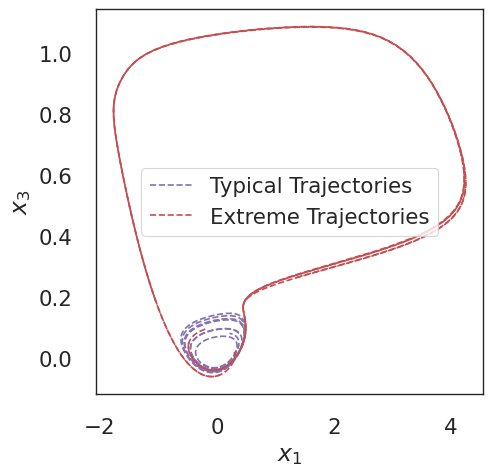

In [87]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
#rc('text', usetex=True)
#rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('xtick.major', pad=12)
rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)

# sns.set(style='whitegrid')
sns.set(style='white')

sns.set_context("paper", font_scale=1.75)

plt.figure(figsize=(5,5))

first = True
for i in range(5):
   # plt.plot(T_long, train_x[:300,:,:2].sum(-1).T/2)
  label = 'Typical Trajectories' if first else None
  first = False
  # plt.plot(T_long, train_x[i,:,:2].sum(-1).T/2, color='C0', linestyle='dashed', lw=1.5, label=label)
  # plt.plot(train_x[i,:,:2].sum(-1).T/2, train_x[i,:,2:].sum(-1).T/2, color='C0', linestyle='solid', lw=1.5, label=label)
  plt.plot(train_x[i,:,1], train_x[i,:,3], color='C4', linestyle='dashed', lw=1.2, label=label)

first = True
for i in range(5):
  label = 'Extreme Trajectories' if first else None
  first = False
  # plt.plot(T_long, train_x[:300,:,:2].sum(-1).T/2)
  idx = extreme_indices[i]
  # plt.plot(train_x[idx,:,:2].sum(-1).T/2, train_x[idx,:,2:].sum(-1).T/2, color='C1', linestyle='solid', lw=1.5, label=label)
  plt.plot(train_x[idx,:,1], train_x[idx,:,3], color='C3', linestyle='dashed', lw=1.2, label=label)
  # plt.plot(T_long, train_x[extreme_indices[i],:,:2].sum(-1).T/2, color='C1', linestyle='dashed', lw=1.5, label=label)

plt.legend()
plt.xlabel('$x_1$') # Time (s)')
plt.ylabel('$x_3$')# r'$\bar{x}$')
plt.savefig('fitzhugh.pdf', bbox_inches='tight')

In [36]:
import tensorflow as tf
tf.config.experimental.set_visible_devices([], "GPU")

from glob import glob
import os
import pickle

from functools import partial  # pylint: disable=g-importing-member
import os
import pickle
import time
import jax
from jax import jit
from jax import random
from jax import vmap
import jax.numpy as jnp
import ml_collections
import numpy as np
import tensorflow as tf
import diffusion
import ode_datasets
import samplers
import unet
from oil.logging.lazyLogger import LazyLogger
from oil.utils.utils import FixedNumpySeed
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

base_path = './all_datasets2'#'./all_datasets4_noic'#'./all_datasets2'
run_path = 'trial4'#'trial4'
obj_name = 'config'
state = []
for name in ['config','data_std','params']:
    with open(os.path.join(base_path,run_path,name), 'rb') as f:
        state.append(pickle.load(f))
    
config, data_std, params = state

key = random.PRNGKey(config.seed)
# Construct the dataset
timesteps = config.dataset_timesteps
with FixedNumpySeed(config.seed):
    ds = getattr(ode_datasets, config.dataset)(N=config.bs+config.ds)


100%|█████████████████████████████████████████████████████████████████████████████████| 450/450 [01:44<00:00,  4.29it/s]


In [37]:
trajectories = ds.Zs[config.bs:, :timesteps]
test_x = ds.Zs[:config.bs, :timesteps]
#data_std = trajectories.std()
T_long = ds.T_long[:timesteps]

In [38]:
with open(f'{config.dataset}_Zs', 'wb') as f:
    pickle.dump((T_long,trajectories,test_x),f)